# TUTORIAL
#### Hi! First time here? You are in the right place to learn how to use the code 

In [1]:
#########################################################################################################################################

##### Do you already have Julia installed?
If not type
```bash
curl -fsSL https://install.julialang.org | sh  # for Linux and mac

winget install julia -s msstore # on Windows
```
More info [here](https://github.com/JuliaLang/juliaup)

In [2]:
#########################################################################################################################################

We start by activating the environment

In [3]:
using Pkg
Pkg.activate(".") # activate the environment in the current directory
# this is needed to use this package without the need to install it from the registry (where the package is not yet registered)
using GW

  Activating project at `/ehome/begnoni/GW.jl`


In [4]:
# these three packages are needed only for the tutorial
using Test
using BenchmarkTools # if you do not have these packages install them with: Pkg.add("BenchmarkTools") and Pkg.add("Test")
using Base.Threads
nthreads()

6

In [5]:
# if this cell returns 1, you need to change your .bashrc file to include the following line:
#     export JULIA_NUM_THREADS = the_number_of_threads_of_your_cpu (e.g.  JULIA_NUM_THREADS = 8) 
# then restart the terminal (or use the command source ~/.bashrc)

## GWJulia is very easy to use
Before detailing the functionalities here we show a minimal example of the code

In [ ]:
parameters = GenerateCatalog(1_000, "BBH"); # generate a catalog of 1_000 BBH systems

Fishers = FisherMatrix(PhenomD(), [CE1Id, CE2NM, ETS], parameters...) # calculate the Fisher matrix for the PhenomD 
                                                            # model with the three detectors CE1Id, CE2NM, and ETS

## FIRST PART: the basics

#### In this first part we will calculate the SNR, the Fisher Matrix and invert it, finally we will obtain the errors estimates.
#### But first we need to decide a waveform model and a detector configuration

In [6]:
# check the waveforms available with this function:
_available_waveforms()
# TaylorF2 is a very basic waveform, not useful
# PhenomD is a good compromise between accuracy and speed for this tutorial. Valid only for BBH
# PhenomXHM is the most accurate waveform. The recommended one for the final results, valid only for BBH (takes a while to compile, order 5 minutes)
# PhenomHM simpler than PhenomXHM, but still accurate. Valid only for BBH
# PhenomD_NRTidal is the PhenomD waveform with the addition of the tidal effects. Valid only for BNS
# PhenomNSBH is the waveform valid for NSBH
# PhenomXAS a more refined and faster version of PhenomD. Valid only for BBH

7-element Vector{String}:
 "TaylorF2"
 "PhenomD"
 "PhenomHM"
 "PhenomD_NRTidal"
 "PhenomNSBH"
 "PhenomXAS"
 "PhenomXHM"

##### The main functions are indicated with the capital letter.
##### The other functions are auxiliary functions, indicated with the underscore.

In [7]:
# check the detectors available with this function
_available_detectors()
# the length in km is the arm length of the detector and it is not needed to call the detector
# e.g. _available_detectors("CE1Id")

The detectors available are: 


11-element Vector{String}:
 "CE1Id, 40km"
 "CE2NM, 20km"
 "CE2NSW, 20km"
 "ETS, 10km"
 "ETLS, 10km"
 "ETMR, 10km"
 "ETLMR, 10km"
 "LIGO_L"
 "LIGO_H"
 "VIRGO"
 "KAGRA"

In [8]:
# now we can decide the waveform, remember the parenthesis (they are needed to define the model structure)

wfPhenomD = PhenomD()
# or use the function _available_waveforms()
wfPhenomD = _available_waveforms("PhenomD")

# then decide the detector
CE_1= CE1Id
# or use the function _available_detectors()
CE_1 = _available_detectors("CE1Id");

# to create a network of detectors put them in an array

CE_2 = CE2NM
ET = ETS

network = [CE_1, CE_2, ET]

3-element Vector{Detector}:
 Detector(0.7649254512715546, -1.9691677285626024, -0.7853981633974483, 1.5707963267948966, 'L', [5.000000000000001, 5.034693157380139, 5.069627037794076, 5.104803311530235, 5.140223660466547, 5.175889778150882, 5.211803369882009, 5.247966152791138, 5.284379855924022, 5.321046220323622  …  4698.324157477345, 4730.924097361, 4763.750236213645, 4796.804143546573, 4830.087399761323, 4863.601596225268, 4897.348335347697, 4931.32923065641, 4965.5459068749, 4999.999999999999], [5.320053993725279e-47, 4.977802675091629e-47, 4.663048207778976e-47, 4.373069475460877e-47, 4.1054566210234874e-47, 3.8580723586682724e-47, 3.6290183152679144e-47, 3.416605735864509e-47, 3.219329997795618e-47, 3.035848361932253e-47  …  1.1542927889652714e-48, 1.1798913424045747e-48, 1.206559811213688e-48, 1.2342718680182324e-48, 1.2630057938779226e-48, 1.2927441289587634e-48, 1.3234733704060701e-48, 1.3551836909058734e-48, 1.387868689337051e-48, 1.421525176464475e-48], "CE1Id")
 Detector(0.

In [9]:
# Let's calculate the SNR of an event with a given waveform and detector

# first we need to define the parameters of the event
mc = 30.0 # chirp mass at the detector frame in solar masses
η = 0.2 # symmetric mass ratio, dimensionless 
χ_1 = 0.1 # dimensionless spin of the most massive BH
χ_2 = 0.2 # dimensionless spin of the least massive BH
dL = 1.0 # luminosity distance in Gpc
θ = 45. * pi/180 # inclination angle in radians
ϕ = 45. * pi/180 # polarization angle in radians
ι = 45. * pi/180 # inclination angle in radians
ψ = 45. * pi/180 # polarisation angle in radians
tcoal = 0.0 # time of coalescence in fraction of a day, [0,1]
Φ_coal = 0.0; # phase of coalescence in radians

parameters = [mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal];

In [10]:
snr = SNR(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal)
# the function returns the SNR of the event, the order of parameters is very important in the code
# first there is the waveform, then there are the intrinsic parameters of the event, then the extrinsic parameters and finally the detector
# in particular, after the waveform, start with the chirp mass, then the symmetric mass ratio, then the spins, then the luminosity distance,
# then the angles, then the time of coalescence and finally the phase of coalescence

# the code requires the least amount of information, so in the SNR there is no need for the phase to coalescence,
# since the SNR depends only on the amplitude, which is independent of the phase.
# Thus the function SNR gives an error if you put also the phase of coalescence

777.6094582520611

In [11]:
# check that you obtained the correct result
snr == 777.6094582520611    # true

true

In [12]:
# or to be fancier, use the Test package
@test snr == 777.6094582520611

Test Passed

In [13]:
#check with the snr calculated by another code (GWFAST)
snrGWFAST = 777.60945825
isapprox(snr,snrGWFAST, rtol = 1e-10)    # true with relative tolerance 1e-10

true

In [14]:
# We can now move to the Fisher matrix of that event but choose a network of detectors
myfisher = FisherMatrix(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, coordinate_shift = false)
# It should take a minute or so because the code needs to be compiled first, each subsequent call will be blitzing fast
# to simplify the notation you can also write 
#myfisher = FisherMatrix(wfPhenomD, parameters..., network)

# the option coordinate_shift is related to T detectors (ET in this case) and represents the fact that the three detectors inside ET are not in the exact same position.
# This produces a difference in phase that improves the estimation of the parameters, but this option is not implemented in GWFAST, so we put it false to do a comparison.
# The default is true, so if you want to use it, you can just remove the option.

# the fisher is a 11x11 matrix (in the BBH case), the order is the same as the inputs.

# the units of the fisher matrix are the inverse of the square of the units of the parameters
# in particular the units of the chirp mass are solar masses, the units of the symmetric mass ratio are dimensionless, the units of the spins are dimensionless,
# the units of the luminosity distance are Gpc, the units of the angles are radians, the units of the time of coalescence are fraction of a day and the units of the phase of coalescence are radians.
# The errors keep the same units except for the time of coalescence, which is converted to seconds.

11×11 Matrix{Float64}:
      1.25029e10  -4.95201e10      -1.29424e10  …  -2.00353e10      8.67874e7
     -4.95201e10   2.02027e11       5.24711e10      9.19228e10     -3.40806e8
     -1.29424e10   5.24711e10       1.36461e10      2.32925e10     -8.92274e7
     -3.61225e9    1.44675e10       3.77269e9       5.85595e9      -2.4962e7
 -15025.3         -6.28205e5   -70159.6            -0.163545        0.0
     -1.44548e8    6.57912e8        1.67127e8   …   4.32171e8      -9.64147e5
     -2.43649e8    1.03555e9        2.66514e8       6.58424e8      -1.66962e6
      4.2846e6    -1.82023e7       -4.64556e6      -6.23763e6   29225.0
      1.74589e8   -6.85794e8       -1.79541e8      -2.71056e8       1.21621e6
     -2.00353e10   9.19228e10       2.32925e10      7.69501e10     -1.34815e8
      8.67874e7   -3.40806e8       -8.92274e7   …  -1.34815e8       6.04676e5

In [15]:
# this is a comparison of the Fisher matrix calculated by the code and the Fisher matrix calculated by GWFAST, we only compare one row but the result is valid for the whole matrix (in the limit of machine precision)
fisher_first_row_GWFAST = [1.25028777e+10, -4.95201244e+10, -1.29423577e+10, -3.61224785e+09, -1.50253200e+04, -1.44547812e+08, -2.43648573e+08, 4.28460151e+06, 1.74588867e+08, -2.00352948e+10,
                        8.67874125e+07]
isapprox(myfisher[1,:], fisher_first_row_GWFAST, rtol = 1e-8)    # true with relative tolerance 1e-8


true

In [14]:
# we can then calculate the covariance matrix by inverting the Fisher matrix
mycovariance = CovMatrix(myfisher)

11×11 Matrix{Float64}:
  7.23242e-7  -3.2975e-7    1.08466e-6   …   3.0717e-8   -3.32002e-5
 -3.2975e-7    6.54296e-7  -1.1187e-5        4.10002e-7   1.26942e-5
  1.08466e-6  -1.1187e-5    0.000253739     -1.02455e-5  -0.00012387
  2.16537e-6   2.7996e-5   -0.000698006      2.89052e-5   0.000192447
 -1.01296e-7   5.55902e-7  -1.14271e-5       4.84782e-7  -9.02915e-6
 -7.56714e-9   6.4974e-9   -1.96666e-7   …   5.14175e-9  -3.3578e-7
 -1.01271e-8   2.18286e-8  -2.66614e-7      -1.61353e-8   8.01447e-6
 -2.95392e-8  -2.48429e-7   5.97057e-6      -2.87899e-7   5.39887e-6
 -1.00872e-7  -7.77319e-8   2.4162e-6       -9.98621e-8  -0.000267982
  3.0717e-8    4.10002e-7  -1.02455e-5       4.24692e-7   2.94364e-6
 -3.32002e-5   1.26942e-5  -0.00012387   …   2.94364e-6   0.00280405

In [15]:
# we can now calculate the errors on the parameters
myerrors = Errors(mycovariance)
parameters_string = ["mc", "η", "χ_1", "χ_2", "dL", "θ", "ϕ", "ι", "ψ", "tcoal", "Φ_coal"]

for i in eachindex(myerrors)
    println("The error on $(parameters_string[i]) is $(myerrors[i])")
end

The error on mc is 0.0008504360749730822
The error on η is 0.000808885606128527
The error on χ_1 is 0.015929173872294648
The error on χ_2 is 0.044367410029956963
The error on dL is 0.007751205023032693
The error on θ is 0.0004336067649812443
The error on ϕ is 0.0019172151420981257
The error on ι is 0.009008641014767917
The error on ψ is 0.011691407428797717
The error on tcoal is 0.0006516841768254732
The error on Φ_coal is 0.05295327234454468


In [ ]:
# check the values of the errors with the values calculated by GWFAST
errors_GWFAST = [0.00085044, 0.00080889 , 0.01592917, 0.04436741, 0.00775121, 0.00043361, 0.00191722, 0.00900864, 0.01169141, 0.00065168, 0.05295327]
isapprox(myerrors, errors_GWFAST, rtol = 1e-6)    # true with relative tolerance 1e-6


true

In [17]:
# obtaint the sky area of the event
sky_area = SkyArea(mycovariance, θ) # the angle is in grad and represents the 90% credible interval
# for different credible intervals you can use the function SkyArea(mycovariance, θ, credible_interval = 0.68) or 0.95

0.024299733801812353

### This is the end of the first part of the tutorial
#### In the second part we will dig a bit deeper into the code and see how to use the catalog module to generate a catalog of events

In [18]:
#################################################################################################################################################################################

# Second part: generate a catalog, the detector structure and loops
### The detector structure

In [19]:
# In the next cells we will go through the detector structure in the code,
# if you will use the detectors already present in the code you can skip this part.
# A detector in the code is a structure with the following fields

fieldnames(typeof(CE_1))


(:latitude_rad, :longitude_rad, :orientation_rad, :arm_aperture_rad, :shape, :fNoise, :psd, :label)

In [20]:
# to see what each field contains, use the following loop
for field in fieldnames(typeof(CE_1))
    println("$(field): $(getfield(CE_1, field))")
end

latitude_rad: 0.7649254512715546
longitude_rad: -1.9691677285626024
orientation_rad: -0.7853981633974483
arm_aperture_rad: 1.5707963267948966
shape: L
fNoise: [5.000000000000001, 5.034693157380139, 5.069627037794076, 5.104803311530235, 5.140223660466547, 5.175889778150882, 5.211803369882009, 5.247966152791138, 5.284379855924022, 5.321046220323622, 5.357966999113357, 5.395143957580921, 5.432578873262691, 5.4702735360287145, 5.508229748168284, 5.546449324476114, 5.584934092339116, 5.623685891823759, 5.66270657576406, 5.701998009850165, 5.7415620727175565, 5.7814006560368805, 5.821515664604383, 5.861909016432995, 5.902582642844027, 5.9435384885595175, 5.984778511795218, 6.026304684354212, 6.068118991721205, 6.110223433157443, 6.1526200217963085, 6.195310784739582, 6.238297763154348, 6.281583012370604, 6.325168601979518, 6.369056615932394, 6.4132491526403035, 6.457748325074419, 6.5025562608670455, 6.547675102413337, 6.593107006973743, 6.63885414677715, 6.684918709124732, 6.731302896494551,

In [4]:
# If you want to define your detector from scratch you can do it like

my_detector = Detector(43.827 * pi/180,
                                 -112.825 * pi/180,
                                  -45 * pi/180,
                                   90. * pi/180,
                                    'L',
                                 _readASD("useful_files/CE_curves/cosmic_explorer.txt")...,
                                  "mydetector"
                                ) # in julia "" and '' are NOT equivalent, "s" is a string, 's' is a character

# the function _readASD reads the asd (amplitude spectral density) and outputs the psd (power spectral density) 
# It reads from a file which must have at least two columns, the first is the frequency and the second the asd
# if the file has more columns, to read other columns you can add them as arguments of the function _readASD("path", col=[1,3]) for example to read the first and third column
# the function returns the frequency and the psd, so you can use the splat operator (the dots) to pass the arguments to the Detector structure

# the detector structure is mutable, so you can change the values of the fields as you like, but remember that the fields are in the order of the constructor and you need to initialize all of them


Detector(0.7649254512715546, -1.9691677285626024, -0.7853981633974483, 1.5707963267948966, 'L', [5.000000000000001, 5.034693157380139, 5.069627037794076, 5.104803311530235, 5.140223660466547, 5.175889778150882, 5.211803369882009, 5.247966152791138, 5.284379855924022, 5.321046220323622  …  4698.324157477345, 4730.924097361, 4763.750236213645, 4796.804143546573, 4830.087399761323, 4863.601596225268, 4897.348335347697, 4931.32923065641, 4965.5459068749, 4999.999999999999], [5.320053993725279e-47, 4.977802675091629e-47, 4.663048207778976e-47, 4.373069475460877e-47, 4.1054566210234874e-47, 3.8580723586682724e-47, 3.6290183152679144e-47, 3.416605735864509e-47, 3.219329997795618e-47, 3.035848361932253e-47  …  1.1542927889652714e-48, 1.1798913424045747e-48, 1.206559811213688e-48, 1.2342718680182324e-48, 1.2630057938779226e-48, 1.2927441289587634e-48, 1.3234733704060701e-48, 1.3551836909058734e-48, 1.387868689337051e-48, 1.421525176464475e-48], "mydetector")

### Catalogs

In [22]:
# To create a catalog you need to decide the number of events and the population (BBH, BNS or NSBH)
# this function writes the catalog as a .h5 file in the folder catalogs/
# the function returns the parameters of the events in the catalog
nEvents = 1_000
name = "my_first_catalog.h5"
typeof_events = "BBH"
mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal = GenerateCatalog(nEvents, typeof_events, name_catalog = name)


([39.86775421827208, 23.381459148454, 43.85559538222094, 17.327748624657023, 70.82556951720427, 36.681747029916096, 29.307557709474512, 62.221115563747254, 42.43943192103832, 196.35741905144428  …  18.718161666226568, 18.388971871015066, 40.599100913703545, 16.063876020307603, 14.57403154597805, 109.26821665036177, 11.965407424762235, 16.640784952321038, 125.53191716897125, 69.91731063456575], [0.24957694941298356, 0.24975587201474958, 0.2483932234610741, 0.24970999594810878, 0.24955103730416855, 0.2494214394048676, 0.24529212517272728, 0.24982652025551236, 0.24983357470214826, 0.17801285680187676  …  0.2492641855124982, 0.24959248711381024, 0.2478328197432557, 0.24994988953644143, 0.24966044460570708, 0.2495530799012044, 0.2499991154560884, 0.23540579813452614, 0.24987028729866284, 0.2384289380624333], [-0.15030385368916915, 0.09589839247751161, 0.21446638727460918, -0.10523080148832238, -0.1801099251838024, -0.1157892668795936, -0.29610703532017646, -0.20804326523647818, 0.1223594347

In [23]:
### After you create the catalog you can read it with the following function
# note that is also prints some useful information about the catalog contained in the .h5 file
mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal = ReadCatalog(name)
# time_delay_in_Myrs represents the minimum time delay between the formation of the binary and the merger in Myrs

Attributes: ["SFR", "date", "format", "local_rate", "number_events", "population", "seed", "time_delay_in_Myrs", "total_number_sources_yr"]
SFR: Madau&Dickinson
date: Thu 29 Aug 2024 11:33:51
format: GWJulia
local_rate: 17.0
number_events: 1000
population: BBH
seed: 577
time_delay_in_Myrs: 10.0
total_number_sources_yr: 35787.84461570478
Parameters: ["Lambda1", "Lambda2", "chi1", "chi2", "dL", "eta", "iota", "mc", "phi", "phiCoal", "psi", "tcoal", "theta", "z"]


([39.86775421827208, 23.381459148454, 43.85559538222094, 17.327748624657023, 70.82556951720427, 36.681747029916096, 29.307557709474512, 62.221115563747254, 42.43943192103832, 196.35741905144428  …  18.718161666226568, 18.388971871015066, 40.599100913703545, 16.063876020307603, 14.57403154597805, 109.26821665036177, 11.965407424762235, 16.640784952321038, 125.53191716897125, 69.91731063456575], [0.24957694941298356, 0.24975587201474958, 0.2483932234610741, 0.24970999594810878, 0.24955103730416855, 0.2494214394048676, 0.24529212517272728, 0.24982652025551236, 0.24983357470214826, 0.17801285680187676  …  0.2492641855124982, 0.24959248711381024, 0.2478328197432557, 0.24994988953644143, 0.24966044460570708, 0.2495530799012044, 0.2499991154560884, 0.23540579813452614, 0.24987028729866284, 0.2384289380624333], [-0.15030385368916915, 0.09589839247751161, 0.21446638727460918, -0.10523080148832238, -0.1801099251838024, -0.1157892668795936, -0.29610703532017646, -0.20804326523647818, 0.1223594347

### SNRs with for loops and multi-threading

In [24]:
# calculate the SNR for 100 events

snrs = Vector{Float64}(undef, nEvents) # create a vector to store the snrs

@btime for ii in 1:nEvents  # SNR of the first 100 events, the @btime macro is used to measure the time of the operation
    snrs[ii]=SNR(wfPhenomD, network, mc[ii], η[ii], χ_1[ii], χ_2[ii], dL[ii], θ[ii], ϕ[ii], ι[ii], ψ[ii], tcoal[ii])
end


  14.960 s (9064979 allocations: 1.20 GiB)


In [25]:
# if the number of events is larger than 100 we suggest to go multi-thread (up to now everything was done with a single thread)
# check the number of threads available with
nthreads()

2

In [26]:
# calculate the SNR, this time with multi-threading 

snrs = Vector{Float64}(undef, nEvents)
@btime @threads for ii in 1:nEvents # the @threads macro is used to parallelize the for loop
    snrs[ii]=SNR(wfPhenomD, network, mc[ii], η[ii], χ_1[ii], χ_2[ii], dL[ii], θ[ii], ϕ[ii], ι[ii], ψ[ii], tcoal[ii])
end

# the time should be smaller than the previous one, if not, try to increase the number of sources

  5.273 s (9068395 allocations: 1.20 GiB)


In [27]:
# All that we did so far can be automatized with the SNR function
# we just need to pass all the parameter to the SNR function, it will already parallelize the calculation
# it will return the SNRs and if you use the flag "auto_save=true" it will save them in a file called SNRs.h5 in the folder output/BBH
# to change the destination folder you can use the flag "name_folder = "path/to/folder""

snrs = SNR(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, auto_save=true);
# the output is a vector with the SNRs of the events

Computing SNRs... 100%|██████████████████████████████████| Time: 0:00:05


SNRs computed!
The evaluation took: 5.984219981 seconds.


### Fisher matrix with for loops and multi-threading

In [28]:
# We can reproduce the steps we did before for the SNRs

nPar = 11 # number of parameters of the binary system for BBH
# to speed things up we do not calculate the Fisher matrix for all the events, but only for the first 100
Fisher = Array{Float64}(undef, 100, nPar, nPar)   # create a 3D array to store the Fisher matrices

@time for ii in 1:100
    Fisher[ii,:,:] = FisherMatrix(wfPhenomD, network, mc[ii], η[ii], χ_1[ii], χ_2[ii], dL[ii], θ[ii], ϕ[ii], ι[ii], ψ[ii], tcoal[ii], Φ_coal[ii])
end

# here we use the macro @time to measure the time of the operation
# the time takes also into account the compilation time, so the first time you run the code it will be longer than the subsequent times
# instread @btime does more runs of the code to give a more accurate estimate of the time

 32.760559 seconds (21.47 M allocations: 5.886 GiB, 1.43% gc time, 2.42% compilation time)


In [29]:
# As before we can go multi-threading with the macro @threads

Fisher = Array{Float64}(undef, 100, nPar, nPar)
@time @threads for i in 1:100
    Fisher[i,:,:] = FisherMatrix(wfPhenomD, network, mc[i], η[i], χ_1[i], χ_2[i], dL[i], θ[i], ϕ[i], ι[i], ψ[i], tcoal[i], Φ_coal[i])
end


 11.796546 seconds (20.05 M allocations: 5.792 GiB, 2.53% gc time, 1.02% compilation time)


In [30]:
# To do everything together we can use the function FisherMatrix passing directly the parameters of the events
# the function will calculate the Fisher matrix for all the events and save them in a file called fisher.h5 in the folder output/BBH
# to change the destination folder you can use the flag "folder = "path/to/folder""
# the function will also return the Fisher matrices
# the function calculates also the SNRs, so you do not need to calculate them before
# if you want to return the SNRs use the flag "return_SNR = true"
# if you save the Fisher matrices you also save the SNRs if the return_SNR flag is true 

Fisher, SNRs = FisherMatrix(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, return_SNR = true, auto_save=true);

# the output of the FisherMatrix function is a 3D array with the Fisher matrices of the events and has the same structure as the Fisher array created
# before. Thus Fisher[1,:,:] is the Fisher matrix of the first event, Fisher[:,1,1] is the first element of the Fisher matrix of all the events and so on.

Computing Fishers and SNRs... 100%|██████████████████████| Time: 0:01:59


Fisher matrices and SNRs computed!
The evaluation took: 1.9968122560833335 minutes.


In [31]:
# to add the correction due to Earth motion just add the flag "useEarthMotion = true"

Fisher, SNRs = FisherMatrix(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, return_SNR = true, auto_save=true, useEarthMotion = true);


Computing Fishers and SNRs... 100%|██████████████████████| Time: 0:02:17


Fisher matrices and SNRs computed!
The evaluation took: 2.2958933538666666 minutes.


##### Changing the SNR threshold

In [32]:
# the SNRs are calculated before the Fisher because under a threshold the Fisher matrix is not calculated, so the SNRs are needed to filter the events.
# The threshold is set to 12, but you can change it with the flag "rho_thres = value", e.g. rho_thres = 10.
# if you want to calculate the Fisher matrix for all the events, you can set the threshold to nothing, "rho_thres = nothing",
# this way it will not calculate the SNRs

Fisher_no_thres = FisherMatrix(wfPhenomD, network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, rho_thres = nothing);


Computing Fishers... 100%|███████████████████████████████| Time: 0:01:56


Fisher matrices computed!
The evaluation took: 1.9344797697 minutes.


In [33]:
# if an event is under the threshold, the Fisher matrix is not calculated and the code returns a matrix of zeros
# this choice was made to keep track of which event correspond to which Fisher matrix.
# To select only the events above the threshold just type

Fisher_above_thres = Fisher[Fisher[:,1,1].!=0,:,:];
println("The number of events above the threshold is $(size(Fisher_above_thres)[1])")


The number of events above the threshold is 975


In [34]:
# To read the Fisher matrices and the SNRs you can use the following function
Fishers, SNRs = _read_Fishers_SNRs("output/BBH/Fishers_SNRs.h5")

Attributes: ["Detectors", "What_this_file_contains", "date", "number_events"]
Detectors: ["CE1Id", "CE2NM", "ETS"]
What_this_file_contains: This file contains the Fishers and the SNRs for 1000 events obtained with the PhenomD waveform model. The calculations are performed with the CE1Id,CE2NM,ETS detectors and the correction due to Earth Motion was true.
date: Thu 29 Aug 2024 11:40:11
number_events: 1000
Keys: ["Fishers", "SNRs"]


([1.877437217319135e6 -2.767026111399725e7 … -6.698647715054607e6 27748.587028090165; 5.261288435216465e7 1.7761270322095746e8 … -5.383445308380147e7 187882.95200084886; … ; 184875.23827587563 1.3719766757432127e8 … -1.0771551991054712e7 59983.74084163664; 2.814552160075701e6 -7.029340304806478e7 … -3.801051030533539e7 186358.19799716986;;; -2.767026111399725e7 4.174204415373163e8 … 1.1287069906926627e8 -406399.8032739847; 1.7761270322095746e8 6.191217000310106e8 … -2.2116644313648748e8 629282.1835697107; … ; 1.3719766757432127e8 1.0624475945333546e11 … -8.872846785793274e9 4.433551387441255e7; -7.029340304806478e7 1.7837420563172889e9 … 1.0357901585063926e9 -4.632107465242265e6;;; -2.0373995624520986e6 3.051427802228695e7 … 7.886884150909597e6 -29965.203019452816; -1.85428018944383e7 -6.40080585055137e7 … 2.1285049531773992e7 -65767.94060025056; … ; -1.9358789054376727e6 -1.4512678489461627e9 … 1.1558080558142938e8 -627299.5683103601; -1.2090547105277734e7 3.060192505193164e8 … 1.7549

In [35]:
# To extract the covariance do as before but with for loops
nPar = 11
covs = Array{Float64}(undef, nEvents, nPar, nPar)
for ii in 1:nEvents
    covs[ii,:,:] = CovMatrix(Fisher[ii,:,:], debug = false)
end
# if the covariance matrix is singular, the function will return a matrix with zeros, this will happen if the event is poorly 
# resolved (usually in the case of one or two detectors). In this case, the code will also return a warning message if the flag debug = true, one message for each event.

In [36]:
# Then to extract the errors
errors = Array{Float64}(undef, nEvents, nPar)
for ii in 1:nEvents
    errors[ii,:] = Errors(covs[ii,:,:])
end

In [37]:
# To extract the sky area then
sky_areas = Vector{Float64}(undef, nEvents)
for i in 1:nEvents
    sky_areas[i] = SkyArea(covs[i,:,:], θ[i])
end

In [ ]:
# As before CovMatrix, Errors and SkyArea can accept directly the Fisher matrix and return the covariance matrix and the errors
covs = CovMatrix(Fisher)
errors = Errors(covs)
sky_areas = SkyArea(covs, θ)

# if the flag debug is set to true, the code will print a warning message if the covariance matrix is singular, one message for each event.
# Moreover it will print informations about the inversion.
# Even if debug = false it will print anyway a summary message with the number of failed inversions.


In [38]:
# through out the tutorial we inizialed the empty arrays with undef, but you can also initialize them with zeros
# e.g. covs = zeros(nEvents, nPar, nPar)

In [39]:
#################################################################################################################################################################################

## Third Part: BNS and NSBH

In [40]:
# We do as before but this time we need to include the deformabilities of the neutron stars
# Λ_1 and Λ_2, they are dimensionless, in the case of BBH they are set to 0.
# The function GenerateCatalog will generate the catalog with the deformabilities

nEvents = 1_000
name = "my_first_catalog_of_BNS.h5"
typeof_events = "BNS"
mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, Λ_1, Λ_2 = GenerateCatalog(nEvents, typeof_events, name_catalog = name)

([4.089279528326645, 2.457484651016277, 6.414039535825347, 3.7237137332840944, 2.431722060115616, 3.5875598094185985, 3.3247366441360784, 18.44261631919743, 2.492081002601522, 3.4591497755943754  …  7.152882391083955, 4.853809571052641, 2.8760373203486527, 2.700334105850016, 6.437210846968576, 3.1324395278389288, 2.241147058267415, 4.926803178986158, 9.424607704963048, 2.9438369700164166], [0.2301715207241825, 0.23861048521391728, 0.24966601876061612, 0.23694408440101464, 0.24879299224853735, 0.2446097456716885, 0.23702142779183039, 0.2484560253244246, 0.24458846313582364, 0.24631810480977306  …  0.24466521059611682, 0.2438489950189752, 0.24833769595097316, 0.2411599812549074, 0.2492997721730525, 0.24075967741140786, 0.24924362377097106, 0.2490029574849458, 0.2366753691856254, 0.24987767411317086], [-0.03015966134313235, 0.036571486669835215, 0.03512403365560422, 0.01849152310723548, 0.0165089500415945, 0.017107073585513166, -0.00899171392988507, -0.02361726677849061, 0.016211268901158

In [41]:
# we can read the catalog as before
mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, Λ_1, Λ_2 = ReadCatalog(name)

Attributes: ["SFR", "date", "format", "local_rate", "number_events", "population", "seed", "time_delay_in_Myrs", "total_number_sources_yr"]
SFR: Madau&Dickinson
date: Thu 29 Aug 2024 11:42:09
format: GWJulia
local_rate: 105.5
number_events: 1000
population: BNS
seed: 2377
time_delay_in_Myrs: 10.0
total_number_sources_yr: 222095.15335040318
Parameters: ["Lambda1", "Lambda2", "chi1", "chi2", "dL", "eta", "iota", "mc", "phi", "phiCoal", "psi", "tcoal", "theta", "z"]


([4.089279528326645, 2.457484651016277, 6.414039535825347, 3.7237137332840944, 2.431722060115616, 3.5875598094185985, 3.3247366441360784, 18.44261631919743, 2.492081002601522, 3.4591497755943754  …  7.152882391083955, 4.853809571052641, 2.8760373203486527, 2.700334105850016, 6.437210846968576, 3.1324395278389288, 2.241147058267415, 4.926803178986158, 9.424607704963048, 2.9438369700164166], [0.2301715207241825, 0.23861048521391728, 0.24966601876061612, 0.23694408440101464, 0.24879299224853735, 0.2446097456716885, 0.23702142779183039, 0.2484560253244246, 0.24458846313582364, 0.24631810480977306  …  0.24466521059611682, 0.2438489950189752, 0.24833769595097316, 0.2411599812549074, 0.2492997721730525, 0.24075967741140786, 0.24924362377097106, 0.2490029574849458, 0.2366753691856254, 0.24987767411317086], [-0.03015966134313235, 0.036571486669835215, 0.03512403365560422, 0.01849152310723548, 0.0165089500415945, 0.017107073585513166, -0.00899171392988507, -0.02361726677849061, 0.016211268901158

In [42]:
# we can calculate the SNRs but we need to pay attention to the number and order of parameters
# the order is mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, detector, Λ_1, Λ_2

snrs = SNR(PhenomD_NRTidal(), network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Λ_1, Λ_2, auto_save=true, name_folder = "BNS");

Computing SNRs... 100%|██████████████████████████████████| Time: 0:00:06


SNRs computed!
The evaluation took: 6.85778233 seconds.


In [43]:
# same as before we can calculate the Fisher matrices
# we also introduce another detector in the network
# the network is now [CE_1, CE_2, ET, my_detector]
my_network = [CE_1, CE_2, ET, my_detector]
Fisher_BNS, SNRs_BNS = FisherMatrix(PhenomD_NRTidal(), my_network, mc, η, χ_1, χ_2, dL, θ, ϕ, ι, ψ, tcoal, Φ_coal, Λ_1, Λ_2, return_SNR = true,
                                     auto_save=true, name_folder = "BNS/with_my_detector");
# note that I added to the name_folder "with_my_detector" to create a new folder

Computing Fishers and SNRs... 100%|██████████████████████| Time: 0:02:58


Fisher matrices and SNRs computed!
The evaluation took: 2.9829652001166664 minutes.


In [44]:
# To read the Fisher matrices and the SNRs you can use the following function
Fishers, SNRs = _read_Fishers_SNRs("output/BNS/with_my_detector/Fishers_SNRs.h5")

Attributes: ["Detectors", "What_this_file_contains", "date", "number_events"]
Detectors: ["CE1Id", "CE2NM", "ETS", "mydetector"]
What_this_file_contains: This file contains the Fishers and the SNRs for 1000 events obtained with the PhenomD_NRTidal waveform model. The calculations are performed with the CE1Id,CE2NM,ETS,mydetector detectors and the correction due to Earth Motion was false.
date: Thu 29 Aug 2024 11:45:16
number_events: 1000
Keys: ["Fishers", "SNRs"]


([0.0 0.0 … 0.0 0.0; 3.5815526431071816e12 -2.0603140952212284e10 … -9473.066524401456 -3049.9528171934808; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN;;; 0.0 0.0 … 0.0 0.0; -2.0603140952212284e10 1.3293329347687444e8 … 90.74237001312758 27.052588252833033; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN;;; 0.0 0.0 … 0.0 0.0; -1.5917137934087538e10 9.555419760808896e7 … 51.47493813898847 16.0184231501178; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN;;; … ;;; 0.0 0.0 … 0.0 0.0; 3.1646202799164534e7 -179440.16242044768 … -0.08023945916746586 -0.026017587141199207; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN;;; 0.0 0.0 … 0.0 0.0; -9473.066524401456 90.74237001312758 … 0.0004826627948958241 0.0001252592759429701; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN;;; 0.0 0.0 … 0.0 0.0; -3049.9528171934808 27.052588252833033 … 0.0001252592759429701 3.2614351837395965e-5; … ; 0.0 0.0 … 0.0 0.0; NaN NaN … NaN NaN], [7.430013452113938, 16.74633287357621, 3.2512894200815117, 15.68633180614417, 39.98961819756863, 12.393377

## BONUS: Waveforms

In [45]:
# If you are interested in just the waveforms of the events, you can use the functions
# Ampl (for the amplitude) and Phi (for the phase)

# the functions return the amplitude and the phase of the waveform, the order of the parameters is the same as always
# you also need to provide a frequency (array or float), the function will return the amplitude and the phase at the frequencies of the array (or float)
f = [10.0, 20.0, 30.0, 40.0, 50.0] # frequencies in Hz
amplitude = Ampl(PhenomD(), f, mc[1], η[1], χ_1[1], χ_2[1], dL[1])
phase = Phi(PhenomD(), f, mc[1], η[1], χ_1[1], χ_2[1])

5-element Vector{Float64}:
     0.0
 -3507.5725480946535
 -4295.959626384918
 -4604.112887564544
 -4757.8677269428845

In [46]:
# For PhenomHM() the functions Ampl() and Phase() return a structure with the amplitude for the different higher modes and the phase for the different higher modes

amplitude_HM = Ampl(PhenomHM(), f, mc[1], η[1], χ_1[1], χ_2[1], dL[1])
phase_HM = Phi(PhenomHM(), f, mc[1], η[1], χ_1[1], χ_2[1])

println(fieldnames(typeof(amplitude_HM))) # the structure has the fields :two_one, :two_two, :three_two, :three_three, :four_three, :four_four, representing "\ell,m"

(:two_one, :two_two, :three_two, :three_three, :four_three, :four_four)


In [47]:
# To obtain the full waveform you can use the function hphc() which returns the plus and cross polarizations

h_plus, h_cross = hphc(PhenomHM(), f, mc[1], η[1], χ_1[1], χ_2[1], dL[1], ι[1])
# pay attention that you need to provide the inclination angle (in radians)

(ComplexF64[6.6496880530052805e-25 - 9.276358685686429e-27im, -7.78459084485421e-27 + 2.810364590016157e-25im, -2.6740299158317604e-26 - 1.601642413638991e-25im, 1.7389496772662475e-26 - 1.1758849125846935e-25im, 3.098582671953706e-28 + 9.325916400672623e-26im], ComplexF64[3.315951460921182e-27 + 3.6993344391721254e-25im, -1.5619833096114155e-25 - 5.34917387497679e-27im, 9.029616970387476e-26 - 1.4241538379526096e-26im, 6.508437331034606e-26 + 9.709721461849954e-27im, -5.1777689012164e-26 + 5.568467227641884e-28im])

### If you need more help

In [48]:
# each function that is exported (so the ones that you can use) has a docstring, 
# so you can use the help function to see the documentation

# VSCode has some issues displaying the docstring, so you can use the help function in the REPL
# enter julia in the terminal, activate the project (use the correct path for your machine) and 
# then in help mode type the name of the function you want to know more about

```julia
using Pkg; Pkg.activate("GW.jl"); using GW
? # enter in help mode
hphc    # example of a function to search the docs
```

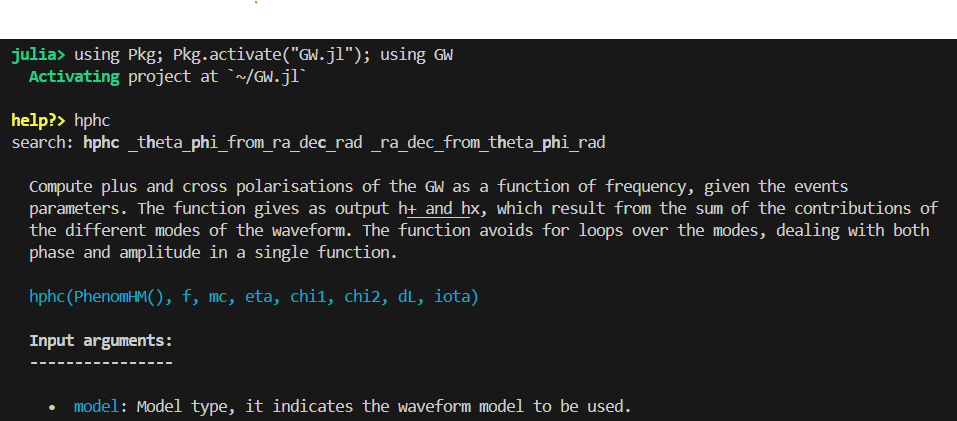

In [ ]:
# Moreover if you do not remember the name of a function you can use 
println(names(GW))
# to see all the functions exported by the package